In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cryptocurrency-historical-prices-top-100-2025/Crypto_historical_data.csv


Shape of dataset: (346260, 8)

Column names:
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ticker', 'name'], dtype='object')

Missing values:
 Date         0
Open      1345
High      1345
Low       1345
Close        0
Volume       0
ticker       0
name         0
dtype: int64

Statistical Summary:
               Open         High          Low        Close  \
count 344,688.0000 344,688.0000 344,688.0000 346,030.0000   
mean    1,699.3931   1,736.4250   1,663.6129   1,694.1972   
std     9,964.9101  10,164.0166   9,777.8737   9,953.5565   
min         0.0000       0.0000      -1.2176       0.0000   
25%         0.1223       0.1289       0.1162       0.1171   
50%         1.0464       1.0894       1.0098       1.0304   
75%        38.0825      39.8584      36.4173      37.2536   
max   125,813.1250 236,493.1719 123,230.8906 125,813.1250   

                       Volume  
count            346,030.0000  
mean       2,538,125,568.5473  
std      274,345,892,861.5193  
min       

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


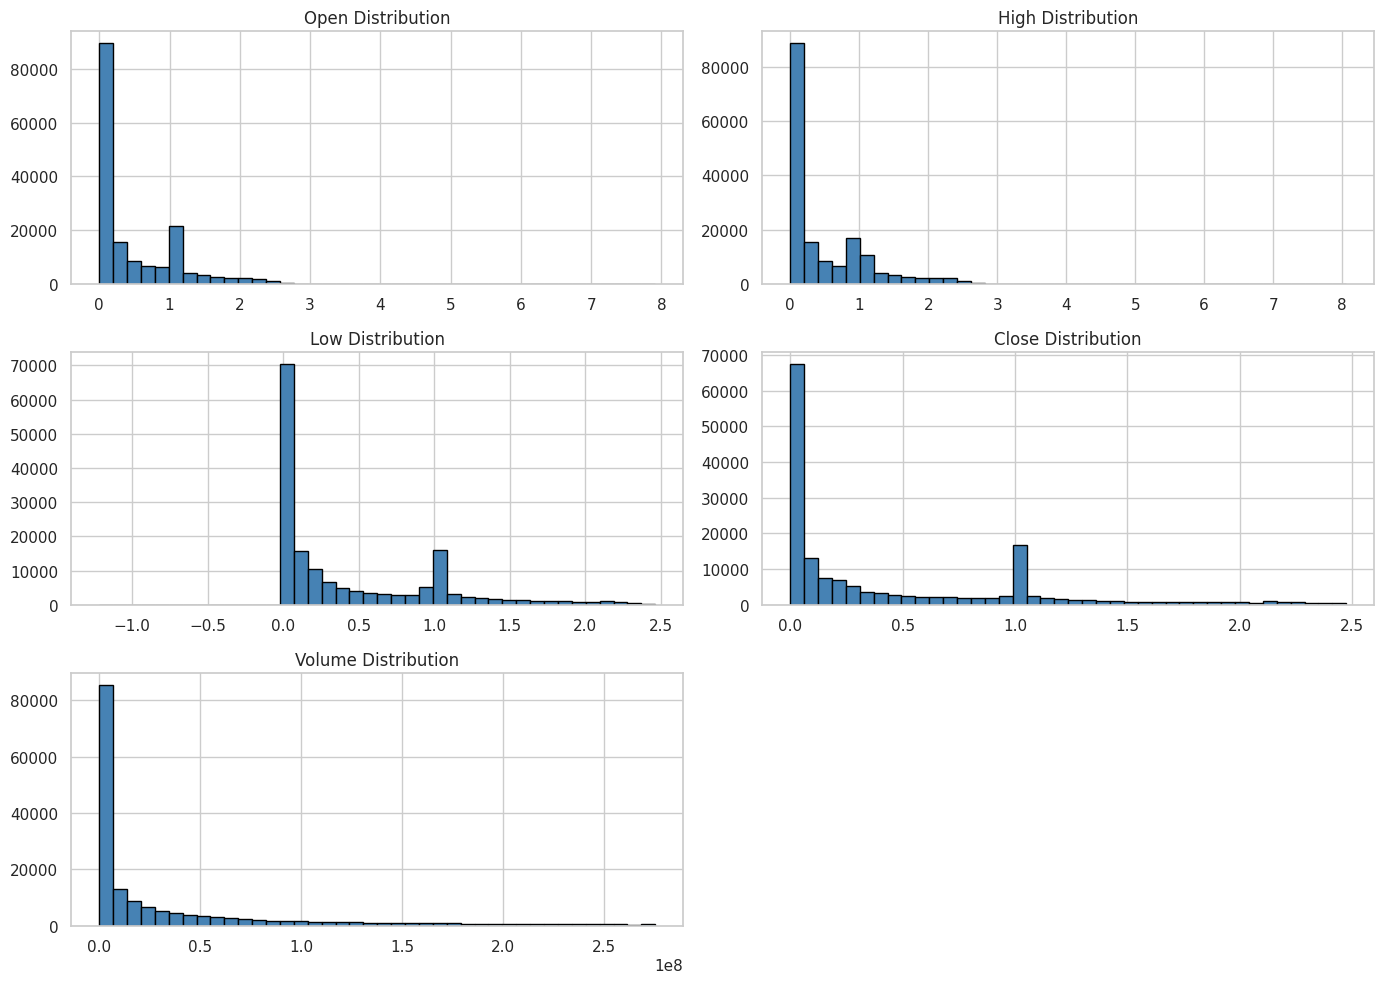

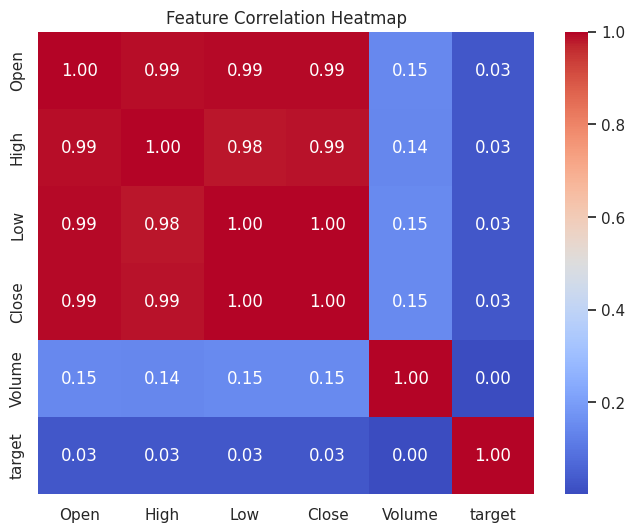


Cleaned dataset preview:


,Date,Open,High,Low,Close,Volume,ticker,name,target
18,2025-10-10 00:00:00+00:00,2.6042,2.7990,1.7721,2.1649,169989840,0G-USD,0G,2.1820
19,2025-10-11 00:00:00+00:00,2.1649,2.4294,2.1416,2.1820,93187425,0G-USD,0G,2.2913
20,2025-10-12 00:00:00+00:00,2.1820,2.3261,2.1107,2.2913,91084722,0G-USD,0G,2.3554
21,2025-10-13 00:00:00+00:00,2.2913,2.3724,2.2152,2.3554,69221689,0G-USD,0G,2.1917
22,2025-10-14 00:00:00+00:00,2.3554,2.3573,2.0790,2.1917,74167526,0G-USD,0G,2.0329


In [9]:

import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set(style="whitegrid")
        
# load
DATA_PATH = '/kaggle/input/cryptocurrency-historical-prices-top-100-2025/Crypto_historical_data.csv'

try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"Couldn't find '{DATA_PATH}'. Please place the file in the working directory.")

# Basic overview
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# ==========================================
# STEP 3: Sort & Feature Engineering
# ==========================================
# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Sort by coin and date to maintain proper order
df = df.sort_values(by=['name', 'Date']).reset_index(drop=True)

# Create target variable — next day closing price
df['target'] = df.groupby('name')['Close'].shift(-1)

# Drop rows where target is missing (last day per coin)
df = df.dropna(subset=['target']).reset_index(drop=True)

# ==========================================
# STEP 4: Numerical Feature Overview
# ==========================================
num_features = ['Open', 'High', 'Low', 'Close', 'Volume']
print("\nStatistical Summary:\n", df[num_features].describe())

# ==========================================
# STEP 5: Outlier Removal (IQR Method)
# ==========================================
def remove_outliers_iqr(data, columns):
    cleaned = data.copy()
    for col in columns:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

df_clean = remove_outliers_iqr(df, num_features)
print(f"\nRows before outlier removal: {len(df)}")
print(f"Rows after outlier removal: {len(df_clean)}")

# ==========================================
# STEP 6: Visualization — Histograms
# ==========================================
plt.figure(figsize=(14, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 2, i)
    plt.hist(df_clean[col], bins=40, color='steelblue', edgecolor='black')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# ==========================================
# STEP 7: Correlation Heatmap
# ==========================================
plt.figure(figsize=(8, 6))
corr = df_clean[num_features + ['target']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# ==========================================
# STEP 8: Final Check
# ==========================================
print("\nCleaned dataset preview:")
display(df_clean.head())


Model Performance Comparison:

                      Model    MAE    RMSE           R²
3  Support Vector Regressor 0.0635  0.1242       0.9574
0         Linear Regression 0.1053  0.1512       0.9368
1             Random Forest 0.0830  5.9784     -97.7648
2         Gradient Boosting 0.1944  9.8518    -267.2030
4                   XGBoost 0.9462 78.3926 -16,980.7969


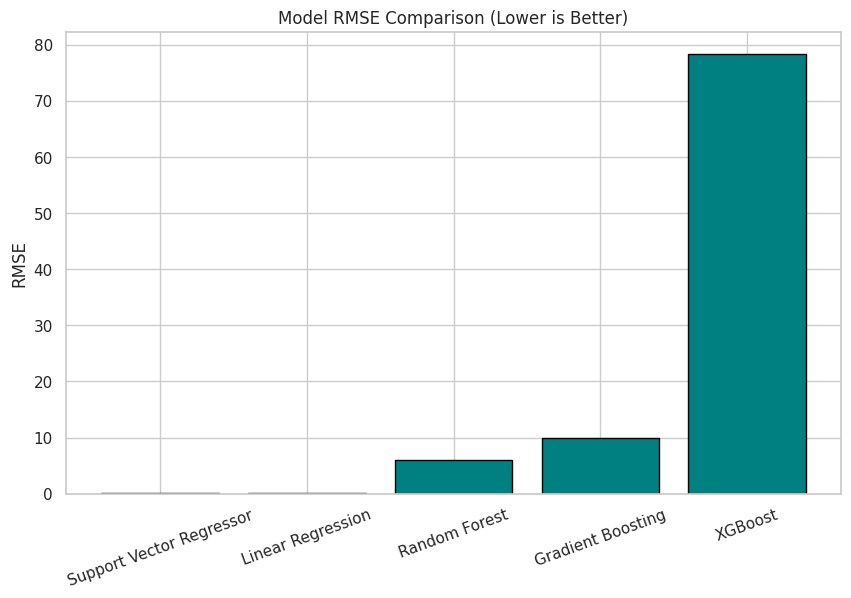


✅ Best performing model: Support Vector Regressor


In [10]:
# ==========================================
# Machine Learning Model Comparison
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================================
# STEP 1: Define Features and Target
# ==========================================
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'target'

X = df_clean[features]
y = df_clean[target]

# ==========================================
# STEP 2: Train-Test Split
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ==========================================
# STEP 3: Feature Scaling
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# STEP 4: Initialize Models
# ==========================================
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, objective='reg:squarederror')
}

# ==========================================
# STEP 5: Train & Evaluate Each Model
# ==========================================
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

# ==========================================
# STEP 6: Create Comparison Table
# ==========================================
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)
print("\nModel Performance Comparison:\n")
print(results_df)

# ==========================================
# STEP 7: Visualize Model Performance
# ==========================================
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['RMSE'], color='teal', edgecolor='black')
plt.title("Model RMSE Comparison (Lower is Better)")
plt.ylabel("RMSE")
plt.xticks(rotation=20)
plt.show()

# ==========================================
# STEP 8: Best Model Selection
# ==========================================
best_model_name = results_df.iloc[0]['Model']
print(f"\n✅ Best performing model: {best_model_name}")
